# Setup: Generate Sample Dataset

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/outliers_homework.csv`.

In [1]:
import os
import numpy as np
import pandas as pd
import sys
sys.path.append("..")
from src.outliers import*

# Define folder paths relative to this notebook
raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

File already exists at ../data/raw/outliers_homework.csv. Skipping CSV creation to avoid overwrite.


# Stage 7 Homework — Outliers + Risk Assumptions
In this assignment you will implement outlier detection/handling and run a simple sensitivity analysis.

**Chain:** In the lecture, we learned detection (IQR, Z-score), options for handling (remove/winsorize), and sensitivity testing. Now, you will adapt those methods to a provided dataset and document the risks and assumptions behind your choices.

In [2]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)

## Load Data (provided or synthetic fallback)

In [3]:
data_path = Path('../data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,date,daily_return,daily_return_2
0,2022-01-03,0.001263,0.003834
1,2022-01-04,-0.020046,-0.009506
2,2022-01-05,0.004739,-0.000535
3,2022-01-06,0.009953,0.012539
4,2022-01-07,0.008872,0.009840


## TODO: Implement Outlier Functions (required)

**move them to ../src/outliers.py**

In [4]:
# def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
#     """Return boolean mask for IQR-based outliers.
#     Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
#     """
#     q1 = series.quantile(0.25)
#     q3 = series.quantile(0.75)
#     iqr = q3 - q1
#     lower = q1 - k * iqr
#     upper = q3 + k * iqr
#     return (series < lower) | (series > upper)

# def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
#     """Return boolean mask for Z-score outliers where |z| > threshold.
#     Assumptions: roughly normal distribution; sensitive to heavy tails.
#     """
#     mu = series.mean()
#     sigma = series.std(ddof=0)
#     z = (series - mu) / (sigma if sigma != 0 else 1.0)
#     return z.abs() > threshold

# df["outliers_iqr"] = detect_outliers_iqr(df["daily_return"],k=1.5)
# df["outliers_zscore"] = detect_outliers_zscore(df["daily_return"],threshold=3.0)
# df
# df.info()

*(Stretch)* Implement winsorizing (optional).

In [5]:
# def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
#     lo = series.quantile(lower)
#     hi = series.quantile(upper)
#     return series.clip(lower=lo, upper=hi)

## Apply Detection and Create Flags (choose a numeric column)

In [6]:
target_col = 'daily_return_2' if 'daily_return_2' in df.columns else df.select_dtypes(include=['number']).columns[0]
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
df[['outlier_iqr', 'outlier_z']].mean()  # fraction flagged
df["outlier_winsorize"] = winsorize_series(df[target_col])
df[['outlier_iqr', 'outlier_z']].mean()

outlier_iqr    0.060870
outlier_z      0.043478
dtype: float64

In [7]:
df

,date,daily_return,daily_return_2,outlier_iqr,outlier_z,outlier_winsorize
0,2022-01-03,0.001263,0.003834,False,False,0.003834
1,2022-01-04,-0.020046,-0.009506,False,False,-0.009506
2,2022-01-05,0.004739,-0.000535,False,False,-0.000535
3,2022-01-06,0.009953,0.012539,False,False,0.012539
4,2022-01-07,0.008872,0.009840,False,False,0.009840
...,...,...,...,...,...,...
110,2022-06-06,-0.010598,-0.001576,False,False,-0.001576
111,2022-06-07,-0.004461,0.002448,False,False,0.002448
112,2022-06-08,-0.011624,-0.013451,False,False,-0.013451
113,2022-06-09,-0.006220,-0.002045,False,False,-0.002045


### Visual Checks (boxplot / histogram)

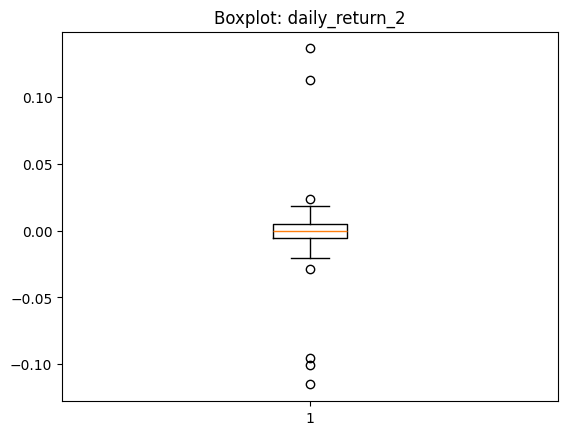

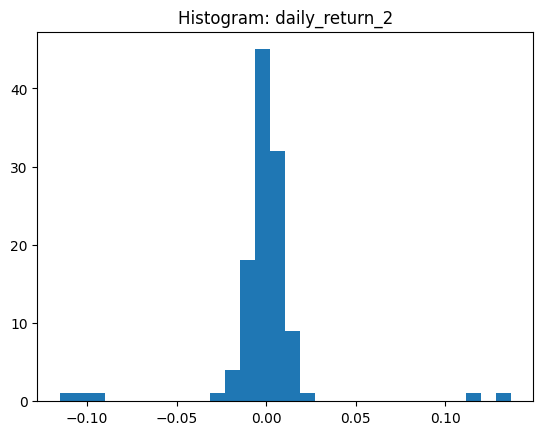

In [8]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

In [9]:
# Option A: Summary stats
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = None
if 'winsorize_series' in globals():
    w = winsorize_series(df[target_col])
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
comp

,all,filtered_iqr,winsorized
mean,-0.000668,-0.000098,-0.000181
median,-0.000174,-0.000173,-0.000174
std,0.025068,0.007744,0.008312


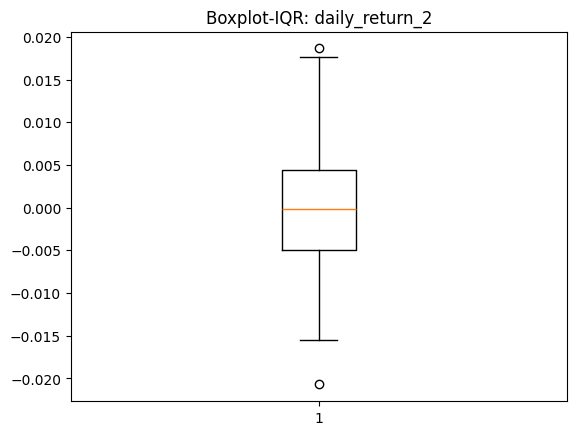

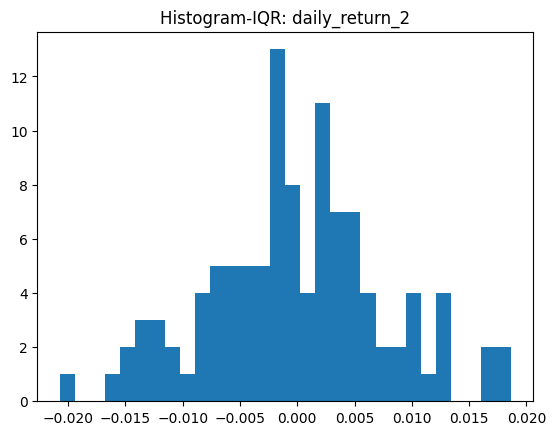

In [10]:
df1 = df.loc[~df["outlier_iqr"],target_col]
plt.figure()
plt.boxplot(df1)
plt.title(f'Boxplot-IQR: {target_col}')
plt.show()

plt.figure()
plt.hist(df1, bins=30)
plt.title(f'Histogram-IQR: {target_col}')
plt.show()


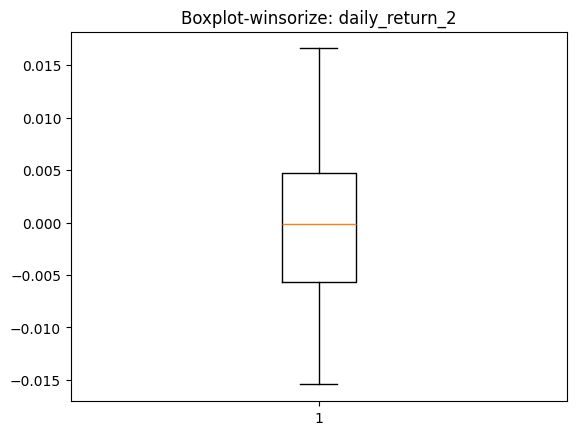

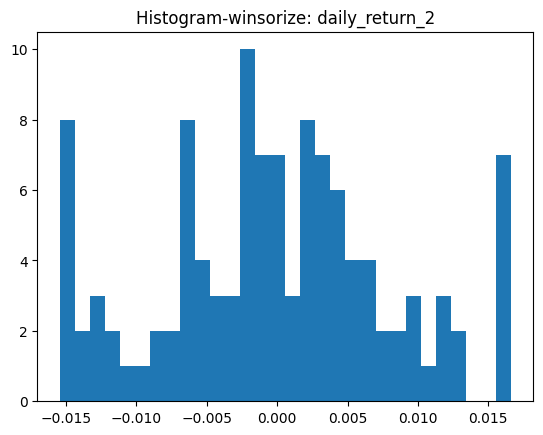

In [11]:
df2 = df["outlier_winsorize"]
plt.figure()
plt.boxplot(df2)
plt.title(f'Boxplot-winsorize: {target_col}')
plt.show()

plt.figure()
plt.hist(df2, bins=30)
plt.title(f'Histogram-winsorize: {target_col}')
plt.show()

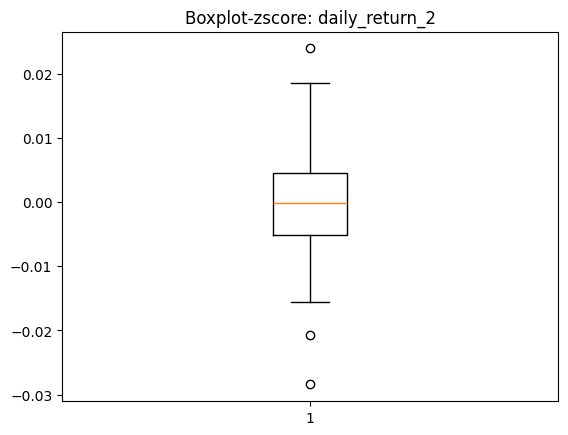

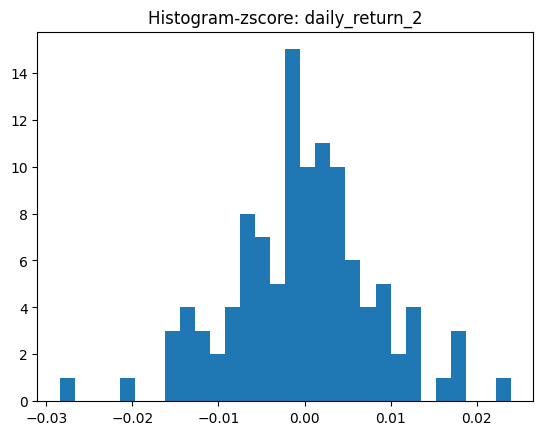

In [12]:
df3 = df.loc[~df["outlier_z"],target_col]
plt.figure()
plt.boxplot(df3)
plt.title(f'Boxplot-zscore: {target_col}')
plt.show()

plt.figure()
plt.hist(df3, bins=30)
plt.title(f'Histogram-zscore: {target_col}')
plt.show()

In [13]:
# Option B: Simple regression (if daily_return present)
if 'daily_return' in df.columns:
    X_all = df[['daily_return']].to_numpy(); y_all = df[target_col].to_numpy()
    X_filtered = df.loc[~df['outlier_iqr'], ['daily_return']].to_numpy(); y_filtered = df.loc[~df['outlier_iqr'], target_col].to_numpy()
    X_win = df[["daily_return"]].to_numpy(); y_win = df["outlier_winsorize"].to_numpy()
    X_z = df.loc[~df["outlier_z"],["daily_return"]].to_numpy();y_z = df.loc[~df["outlier_z"],target_col].to_numpy()

    model_all = LinearRegression().fit(X_all, y_all)
    model_flt = LinearRegression().fit(X_filtered, y_filtered)
    model_win = LinearRegression().fit(X_win,y_win)
    model_zscore = LinearRegression().fit(X_z,y_z)

    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))
    mae_win = mean_absolute_error(y_win,model_win.predict(X_win))
    mae_zscore = mean_absolute_error(y_z,model_zscore.predict(X_z))

    results = pd.DataFrame({
        'slope': [model_all.coef_[0], model_flt.coef_[0],model_win.coef_[0],model_zscore.coef_[0]],
        'intercept': [model_all.intercept_, model_flt.intercept_,model_win.intercept_,model_zscore.intercept_],
        'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered, y_filtered),model_win.score(X_win,y_win),model_zscore.score(X_z,y_z)],
        'mae': [mae_all, mae_flt,mae_win,mae_zscore]
    }, index=['all', 'filtered_iqr',"filtered_winsorized","filtered_zscore"])
    results
else:
    results = None
    print("No 'x' column; skip regression or engineer features.")

In [14]:
results

,slope,intercept,r2,mae
all,0.605869,0.000201,0.961859,0.003951
filtered_iqr,0.598159,-0.000063,0.621966,0.003806
filtered_winsorized,0.118781,-0.000010,0.336244,0.005391
filtered_zscore,0.630315,-0.000088,0.679331,0.003848


### Reflection (≤ 1 page)
- Methods and thresholds used (and why)
- Assumptions behind choices
- Observed impact on results
- Risks if assumptions are wrong (e.g., discarding true events)

**Method&thresholds used**: In this case, I implemented all three IQR, z-score, and winsorized to analyze the case in the beginning. I found out that IQR is the better method to detect the outliers for this case. For the z-score method, it's best to implement at the circumstances that the original data are roughly normal. By reviewing the boxplot of original data, I found out that 50 percent of the points are around 0, and the outliers are spreading out. Therefore, the original data might be heavy-tailed, and it is not safety to implement z-score method at this case. For winsorized method, it disrupt the distrubition the data heavily and it might exclue some importang information, so it's not suitable for this case either. Also, the mean absolute error increase too much after applying linear regression to the data filtered by winsorized, and the slope are drop close to 0 which means there are not strong correlation between independent and dependent variables.

**Assumptions behind choices**: In order to implement IQR, we need to assume the original data are roughly normal distribution. We also assume that the outliers are true outliers and does not contain important information. Based on these assumptions, implementing IQR method is the better method in this case. 

**Observed impact on results**:I implements the IQR methods on both option A & option B. In option A, I found out that the standard deviation of the dataset daily_return_2, drop from 0.025 to 0.0077, and the median did not change much. By reviewing the boxplot and the histogram after implementing IQR method, I found out that the dataset after exclude the outliers might be roughly normal distribution. In option B, I found out that the R squared decline significantly after implementing IQR method on original data. In the original data, the R^2 is too high and it might experience overfitting due to the outliers. After implementing IQR method,R^2 drop to 0.62 but mean absolute error are stable. Implementing winsorized method drop R^2 from 0.96 to 0.33, and we can conclude that winsorize method exclude many vital information. 

**Risks if assumptions are wrong**:If our assumptions are wrong, the distribution of the original data are heavily tailed and outliers are true events, we may discrad many important information, bias on coefficient of the regression, and reduce the predictive performance of the future models I build up. 